In [1]:
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive

rng_key = random.PRNGKey(42)
seed = random.split(rng_key, 5)


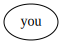

In [2]:
def monty_hall_1():
    theta_you = jnp.ones(3)/3
    you = numpyro.sample("you", dist.Categorical(theta_you), infer={"enumerate": "parallel"})


display(numpyro.render_model(monty_hall_1))


In [3]:
predictive = Predictive(monty_hall_1, num_samples=100, infer_discrete=True)
predictions = predictive(seed[0])
predictions


{'you': DeviceArray([2, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0,
              0, 0, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1,
              1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0,
              1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0,
              1, 2, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1],            dtype=int32)}